In [3]:
# importing data
import numpy as np
D = []
file_path = "Homework 2 data/D2.txt"

with open(file_path, "r") as file:
    for line in file:
        # Split the line into dimensions and label
        parts = line.strip().split()
        if len(parts) == 3:  # Check if the line has both dimensions and a label
            try:
                # Parse dimensions and label as floats and integer
                dim1 = float(parts[0])
                dim2 = float(parts[1])
                label = int(parts[2])

                D.append([dim1, dim2, label])
            except ValueError:
                print(f"Skipping invalid line: {line}")

In [4]:
class Node:
    def __init__(self):
        self.is_leaf = False
        
    def count_internal_nodes(self):
        # Default implementation for LeafNode
        return 0

class LeafNode(Node):
    def __init__(self, class_label=None):
        super().__init__()
        self.is_leaf = True
        self.class_label = class_label

class InternalNode(Node):
    def __init__(self, split_feature=None, split_threshold=None):
        super().__init__()
        self.split_feature = split_feature  # Feature used for splitting
        self.split_threshold = split_threshold  # Threshold for the split
        self.left_child = None  
        self.right_child = None  

    def add_left_child(self, left_child):
        self.left_child = left_child
    
    def add_right_child(self, right_child):
        self.right_child = right_child

    def count_internal_nodes(self):
        # Count this node and recursively count internal nodes in left and right subtrees
        left_count = self.left_child.count_internal_nodes() if self.left_child else 0
        right_count = self.right_child.count_internal_nodes() if self.right_child else 0
        return 1 + left_count + right_count


In [5]:
# Notes: GainRatio(D,S) = InfoGain(D,S)/H_D(S)
#        InfoGain(D,S) = H_D(S) - H_D(Y|S)
#        H_D(S) = -sum(P(y)*log_2(P(y)))        <- emperically determined 
#        H_D(Y|S) = f-sum(P(S=s)H(Y|S=s)) where 
#        H(Y|S=s) = -sum(P(Y=y|S=s)*log_2(P(Y=y|S=s)))

def MakeSubtree(D):

    """ MakeSubtree(set of training instances D)
      C = DetermineCandidateSplits(D)
      if stopping criteria is met
          make a leaf node N
          determine class label for N
      else
          make an internal node N
          S = FindBestSplit(D, C)
          for each group k of S
                  Dk = subset of training data in group k
                  kth child of N = MakeSubtree(Dk)
      return subtree rooted at N """
    
    if len(D) == 0: 
        N = LeafNode() # leaf node N
        N.class_label = 1 # classify y=1 if there's no data
        return N
    
    # check if all the labels are the same. Create leaf node if so
    # Check if all elements in the last column are the same value
    if np.all(D[:, -1] == D[0][-1]):
        N = LeafNode()
        N.class_label = int(D[0][-1])
        return N 
    
    C_x0 = DetermineCandidateSplits(D,0)
    C_x1 = DetermineCandidateSplits(D,1)
    C = np.concatenate((C_x0, C_x1), axis=0)

    if stoppingCriteria(D,C):
        # make leaf node 
        N = LeafNode()
        # determine class label
        labels = D[:, 2]
        # Calculate the mode of the label column
        mode_label = np.argmax(np.bincount(labels))
        # set the leaf value to the most frequent label
        N.class_label = int(mode_label)
    else:
        # make an internal node 
        N = InternalNode()
        S = FindBestSplit(D,C) # returns a single split of the form [x1, x2, label, keyFeatureIndex]

        # get split feature and threshold value
        N.split_feature = int(S[-1])
        featureAxis = int(S[-1])
        N.split_threshold = S[featureAxis]  

        # split the data into left and right childs
        # first, find the indices that sort D along the featureAxis
        sorted_indices = np.argsort(D[:, featureAxis])

        # then, sort D according to these indices 
        Dsorted = D[sorted_indices]

        # find the index in Dsorted corresponding to the best split S
        splitIndex = np.where(np.all(Dsorted == S[0:3], axis=1))
        splitIndex = int(splitIndex[0][0])
        # if there are key feature values in Dsorted with the same featue value but are behind the splitIndex, move the splitIndex down. 
        for j in range(splitIndex):
            # check if we're at the first index
            if splitIndex == 0:
                break
            if Dsorted[splitIndex-1][featureAxis] == S[featureAxis]:
                splitIndex = splitIndex - 1

        Dright = Dsorted[:splitIndex]
        Dleft = Dsorted[splitIndex:]
        Dsplit = [Dleft, Dright]

        for i in range(2): # let i=0 be the left group, i=1 be the right
            Dk = Dsplit[i] 
            if i == 0:
                N.add_left_child(MakeSubtree(Dk))
            else:
                N.add_right_child(MakeSubtree(Dk))

    return N 


def FindBestSplit(D,C):
    gain_ratios = []
    for i in range(len(C)):
        gain_ratios.append(GainRatio_and_SplitEntropy(D,C[i])[0])
    max_index = gain_ratios.index(max(gain_ratios))
    return C[max_index]

# works correctly with example 
def GainRatio_and_SplitEntropy(D,s):
    """ 
    Parameters:
        D: 2D np.array - data features and labels 
        
        s: np.array - a single split with the feature values, label, and feature index intended to split on.
            e.g.: np.array[float, float, int, int] e.g.: [0.234, 1.356, 0, 0]
    Output:
        G: list - the information gain ratio associated to a given split and the entropy of that split.
       """
    def HY(D):
        labels = D[:,2] # array[0,1,1,0,...]
        p_y1 = np.sum(labels)/len(labels) 
        p_y2 = 1 - p_y1
        if p_y1 == 0 or p_y2 == 0:
            return 0 # Entropy is zero if one of the probabilities is zero
        return -(p_y1*np.log2(p_y1 + 1e-10) + p_y2*np.log2(p_y2 + 1e-10)) 

    # calculate H_D(Y) = -sum[P(y)log(P(y))]                    TERM 1
    entropyY = HY(D)

    # calculate H_D(Y|S)                                        TERM 2
    #sort D by xi values into Dleft (>= s) and Dright (< s)
    # sorted_indices = np.argsort(D[:, int(s[3])])
    # Dsorted = D[sorted_indices]

    # # Find the indices where D equals the specified feature values
    # splitIndex = np.where(np.all(Dsorted == s[0:3], axis=1))

    # Dright = Dsorted[:splitIndex[0][0]]
    # Dleft = Dsorted[splitIndex[0][0]:]

    # split the data into left and right childs
    # first, find the indices that sort D along the featureAxis
    featureAxis = int(s[3])
    sorted_indices = np.argsort(D[:, featureAxis])

    # then, sort D according to these indices 
    Dsorted = D[sorted_indices]

    # find the index in Dsorted corresponding to the best split S
    splitIndex = np.where(np.all(Dsorted == s[0:3], axis=1))
    splitIndex = int(splitIndex[0][0])
    # if there are key feature values in Dsorted with the same featue value but are behind the splitIndex, move the splitIndex down. 
    for j in range(splitIndex):
        # check if we're at the first index
        if splitIndex == 0:
            break
        if Dsorted[splitIndex-1][featureAxis] == s[featureAxis]:
            splitIndex = splitIndex - 1

    Dright = Dsorted[:splitIndex]
    Dleft = Dsorted[splitIndex:]


    # calculate H(Y|Sleft) and H(Y|Sright)
    entropyY_given_Sleft = HY(Dleft)
    entropyY_given_Sright = HY(Dright)

    # finally calculate H_D(Y|S)
    Pleft = len(Dleft)/len(D)
    Pright = 1 - Pleft
    entropyY_givenS = Pleft*entropyY_given_Sleft + Pright*entropyY_given_Sright

    # calcualte H_D(S)                                          DENOMINATOR
    l = len(Dleft)
    r = len(Dright)
    t = len(D)
    entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))

    # put it all together                                       FULL EXPRESSION
    GainRatio = (entropyY - entropyY_givenS)/entropyS   

    # check for zero entropies:
    if np.isnan(GainRatio):
        GainRatio = 0.0
    if np.isnan(entropyS):
        entropyS = 0.0
          
    return [GainRatio, entropyS]           


def stoppingCriteria(D,C):
    """ 
     Parameters: D  - np.array with data containing features and labels
                 C  - np.array with rows from D indicating candidate splits and an 
                      extra column indicating the index of the key splitting feature.

     Returns:    bool: weather or not to stop splitting
       """
    if len(D) == 0:
        return True
    # see if H_D(S) = 0 for ALL candidate split
    G = []
    H_S = []
    for i in range(len(C)):
        # calculate GainRatio G and split entropy H_S
        G.append(GainRatio_and_SplitEntropy(D,C[i])[0])
        H_S.append(GainRatio_and_SplitEntropy(D,C[i])[1])
    
    # if the GainRatio or SplitEntropy are zero for all candidate splits, stop.
    if all(item == 0 for item in H_S) or all(item == 0 for item in G):
        return True
    else:
        return False


def DetermineCandidateSplits(D, Xi):
    """ // Run this subroutine for each numeric feature at each node of DT induction
DetermineCandidateNumericSplits(set of training instances D, feature Xi)
      C = {} // initialize set of candidate splits for feature Xi
      let vj denote the value of Xi
      for the jth data point
      sort the dataset using vj
      as the key for each data point
      for each pair of adjacent vj, vj+1 in the sorted order
          if the corresponding class labels are different
              add candidate split vj to C
return C """

    """ Parameters: D  - np.array with two dimensions with features and labels
                    Xi - int index of feature to use for splitting
        Returns:    C  - np.array with two dimensions with candidate splits. The last column
                      in C is key feature that the split is based on.
       """
    
    C = [] # candidate splits for feature Xi
    sorted_indices = np.argsort(D[:, Xi])
    featureColumn = []
    v = D[sorted_indices]
    for i in range(len(v)-1):
        # check for when labels change 
        if v[i,2] != v[i+1,2]:
            # check for duplicate splits 
            # extract column Xi from C
            if len(C) != 0:
                featureColumn = [row[Xi] for row in C]
            # check if v[Xi] is in column. If yes, duplicate is True. Else, duplicate is False.
            duplicate = v[i+1][Xi] in featureColumn
            if (not duplicate):
                C.append(v[i+1])
    C = np.array(C)

    # add column indicating key feature index
    new_column = np.full((C.shape[0], 1), Xi, dtype=int)

    # Append the 'new_column' to C
    C = np.concatenate((C, new_column), axis=1)
    return C

# C = DetermineCandidateSplits(D,0)
# C
# D = np.array([[0,0,1],[0.1,0.2,0],[0.3,0.4,1]])
# s = [0.3,0.4,1,0]
# print(D)
# print(s)
# print(GainRatio_and_SplitEntropy(D,s))
#D = np.vstack((D, [0.2,0.1,0]))
#myTree = MakeSubtree(D)
#print('Done')

## 2.2

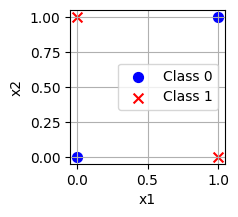

In [5]:
import matplotlib.pyplot as plt
# Data
# class 0: 
x1_0 = [0,1]
x2_0 = [0,1]
# class 1: 
x1_1 = [0,1]
x2_1 = [1,0]

# Scatter plot
plt.figure(figsize=(2, 2))
plt.scatter(x1_0, x2_0, label='Class 0', c='b', marker='o', s=50)
plt.scatter(x1_1, x2_1, label='Class 1', c='r', marker='x', s=50)
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# testing small tree. Indeed, it just creates a leaf. 
D_example = np.array([[0,1,1],[1,0,1],[0,0,0],[1,1,0]])
mySmallTree = MakeSubtree(D_example)
print('Done')

C:\Users\Nicor\AppData\Local\Temp\ipykernel_16236\205858269.py:109: RuntimeWarning: invalid value encountered in scalar divide
  p_y1 = np.sum(labels)/len(labels)
C:\Users\Nicor\AppData\Local\Temp\ipykernel_16236\205858269.py:165: RuntimeWarning: divide by zero encountered in log2
  entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))
C:\Users\Nicor\AppData\Local\Temp\ipykernel_16236\205858269.py:165: RuntimeWarning: invalid value encountered in scalar multiply
  entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))


Done


In [13]:
# show tree structure
def visualize_tree(node, depth=0, parent_prefix="", prefix=""):
    if node is not None:
        if isinstance(node, LeafNode):
            label = "Leaf Node (Class: {})".format(node.class_label)
        elif isinstance(node, InternalNode):
            label = "Internal Node\n(Split: {}, Threshold: {})".format(node.split_feature, node.split_threshold)
        else:
            label = "Node"

        line_prefix = "│   " * depth + parent_prefix
        if depth > 0:
            line_prefix += "├───"

        print(line_prefix + prefix + label)

        if isinstance(node, InternalNode):
            visualize_tree(node.left_child, depth + 1, "└───", "Left: ")
            visualize_tree(node.right_child, depth + 1, "└───", "Right: ")

#visualize_tree(myTree)

# 2.3

In [14]:
import numpy as np
x1_splits = np.array([0.1,-2,0,0])
x2_splits2 = np.array([0,0,0,0])
x2_splits = np.hstack((D, np.ones((len(D),1))   ))
s = np.vstack((x2_splits2,x1_splits,x2_splits))
#s = np.delete(s,1,axis=0)
for i in range(len(s)):
    feature_name = "x1" if int(s[i, -1]) == 0 else "x2"
    feature_value = s[i, int(s[i,-1])]
    gain_ratio = GainRatio_and_SplitEntropy(D, s[i])

    # Print in the specified format
    print(f"Feature: {str(feature_name)}, Feature value: {str(feature_value)}, Gain Ratio: {gain_ratio[0]:.4f}")

C:\Users\Nicor\AppData\Local\Temp\ipykernel_10160\205858269.py:109: RuntimeWarning: invalid value encountered in scalar divide
  p_y1 = np.sum(labels)/len(labels)
C:\Users\Nicor\AppData\Local\Temp\ipykernel_10160\205858269.py:165: RuntimeWarning: divide by zero encountered in log2
  entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))
C:\Users\Nicor\AppData\Local\Temp\ipykernel_10160\205858269.py:165: RuntimeWarning: invalid value encountered in scalar multiply
  entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))


Feature: x1, Feature value: 0.0, Gain Ratio: 0.0000
Feature: x1, Feature value: 0.1, Gain Ratio: 0.1005
Feature: x2, Feature value: -2.0, Gain Ratio: 0.0000


C:\Users\Nicor\AppData\Local\Temp\ipykernel_10160\205858269.py:109: RuntimeWarning: invalid value encountered in scalar divide
  p_y1 = np.sum(labels)/len(labels)
C:\Users\Nicor\AppData\Local\Temp\ipykernel_10160\205858269.py:165: RuntimeWarning: divide by zero encountered in log2
  entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))
C:\Users\Nicor\AppData\Local\Temp\ipykernel_10160\205858269.py:165: RuntimeWarning: invalid value encountered in scalar multiply
  entropyS = -(l/t*np.log2(l/t) + r/t*np.log2(r/t))


Feature: x2, Feature value: -1.0, Gain Ratio: 0.1005
Feature: x2, Feature value: 0.0, Gain Ratio: 0.0560
Feature: x2, Feature value: 1.0, Gain Ratio: 0.0058
Feature: x2, Feature value: 2.0, Gain Ratio: 0.0011
Feature: x2, Feature value: 3.0, Gain Ratio: 0.0164
Feature: x2, Feature value: 4.0, Gain Ratio: 0.0497
Feature: x2, Feature value: 5.0, Gain Ratio: 0.1112
Feature: x2, Feature value: 6.0, Gain Ratio: 0.2361
Feature: x2, Feature value: 7.0, Gain Ratio: 0.0560
Feature: x2, Feature value: 8.0, Gain Ratio: 0.4302


# 2.6 Visualizing tree

In [6]:
def predict_single(node, sample):
    if node.is_leaf:
        return node.class_label

    if sample[node.split_feature] >= node.split_threshold:
        return predict_single(node.left_child, sample)
    else:
        return predict_single(node.right_child, sample)

def predict(tree, data):
    predictions = []
    for sample in data:
        prediction = predict_single(tree, sample)
        predictions.append(prediction)
    return np.array(predictions)

In [7]:
import matplotlib.pyplot as plt
def visualizeTree(tree, D):
    X = D[:, :-1]  # Features
    y = D[:, -1]  # Class labels

    # Make predictions
    # predictions = predict(myTree, data)

    # Create a mesh grid for the feature space
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100),
                        np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100))

    # Flatten the mesh grid to predict for all points in the feature space
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict using the decision tree for all points in the feature space
    predictions = np.array([predict(tree, [point]) for point in grid_points])
    predictions = predictions.reshape(xx.shape)

    # Scatter plot of the dataset
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0', c='r', marker='x', s=50)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1', c='b', marker='o', s=50)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Scatter Plot of Dataset')
    plt.legend()
    plt.grid(True)

    # Visualize decision boundary
    plt.contourf(xx, yy, predictions, cmap=plt.cm.RdYlBu, alpha=0.6)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Tree Decision Boundary')
    plt.grid(True)
    plt.show()

## 2.7 Learning Curve

In [9]:
import numpy as np
# Load the data from Dbig.txt
data = np.genfromtxt("Homework 2 data/Dbig.txt", delimiter=' ')

# Shuffle the data using a random permutation
np.random.seed(4)  
permutation = np.random.permutation(len(data))
shuffled_data = data[permutation]

# Split into training and test sets
training_set = shuffled_data[:8192]
test_set = shuffled_data[8192:]

training_sets = []
decision_trees = []
n_values = [32, 128, 512, 2048, 8192]

for n in n_values:
    # Take the first n items from the shuffled training set
    subset = training_set[:n]
    X_subset = subset[:, :-1]
    y_subset = subset[:, -1]

    # Train a decision tree on the subset
    tree = MakeSubtree(subset)
    print('tree '+str(n)+' done')

    # Append the subset and the corresponding decision tree
    training_sets.append(subset)
    decision_trees.append(tree)

tree 32 done
tree 128 done
tree 512 done
tree 2048 done
tree 8192 done


In [10]:
# Function to count internal nodes starting from a given node
def count_nodes(node):
    if node.is_leaf:
        return 1
    else:
        left_count = count_nodes(node.left_child) if node.left_child else 1
        right_count = count_nodes(node.right_child) if node.right_child else 1
        return 1 + left_count + right_count

n=32, Number of nodes: 11, Test Error: 0.2085
n=128, Number of nodes: 23, Test Error: 0.0575
n=512, Number of nodes: 57, Test Error: 0.0631
n=2048, Number of nodes: 123, Test Error: 0.0299
n=8192, Number of nodes: 259, Test Error: 0.0138


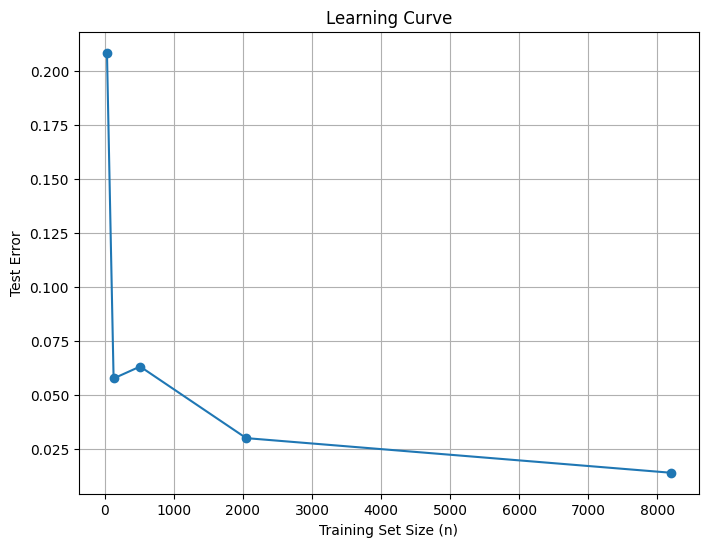

In [11]:
# measure errors and make learning curve
test_errors = []

for tree in decision_trees:
    X_test = test_set[:, :-1]
    y_test = test_set[:, -1]

    # Measure test set error
    test_predictions = predict(tree, test_set)
    errors = test_predictions - y_test
    errors = (errors != 0)
    test_error = np.sum(errors) / len(y_test)
    test_errors.append(test_error)

# Print and plot the results
for n, tree, error in zip(n_values, decision_trees, test_errors):
    print(f"n={n}, Number of nodes: {count_nodes(tree)}, Test Error: {error:.4f}")

# Plot the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(n_values, test_errors, marker='o')
plt.xlabel('Training Set Size (n)')
plt.ylabel('Test Error')
plt.title('Learning Curve')
plt.grid(True)
plt.show()


## visualizing each tree

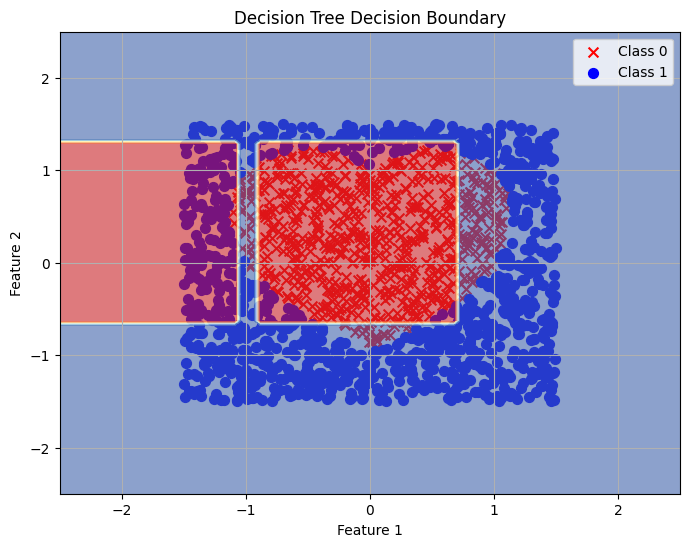

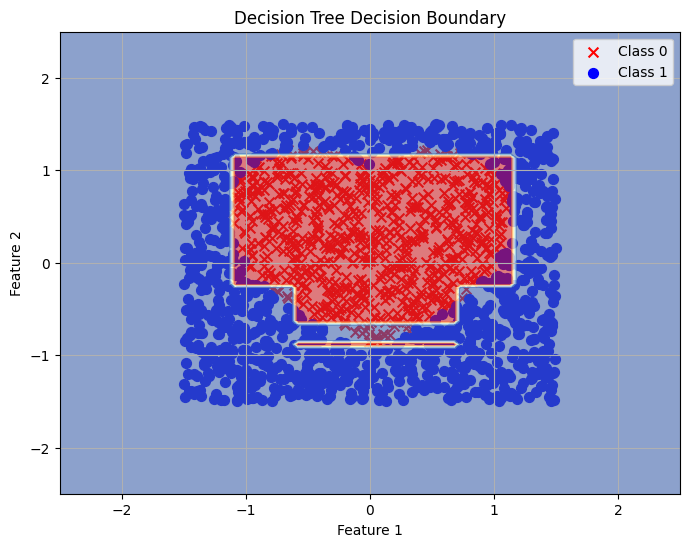

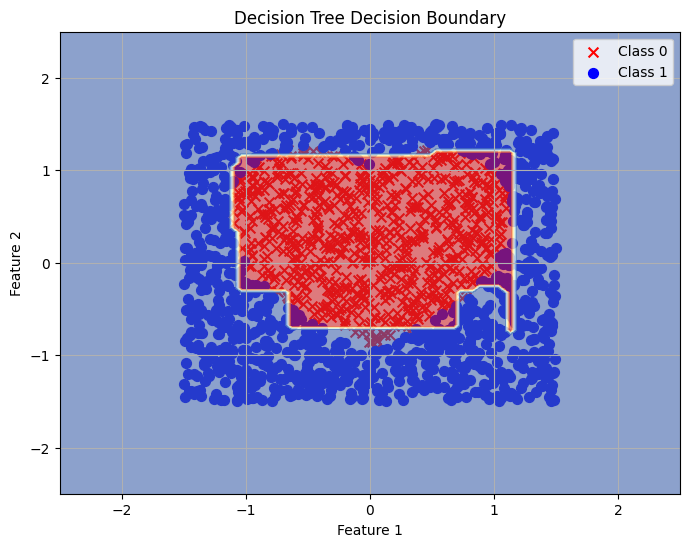

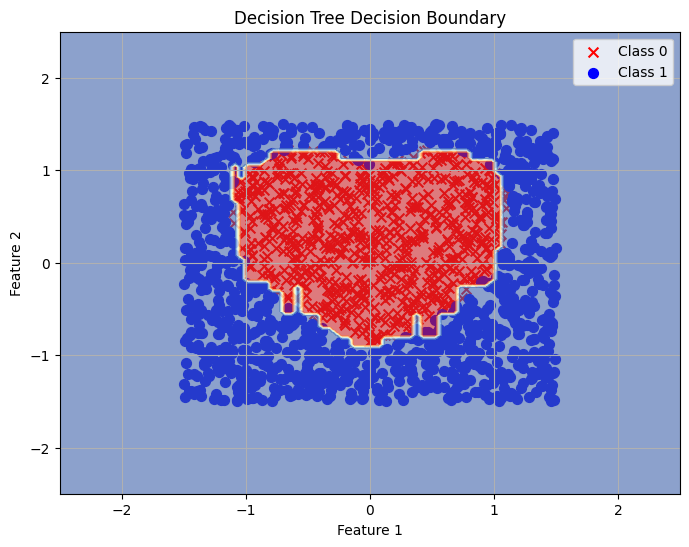

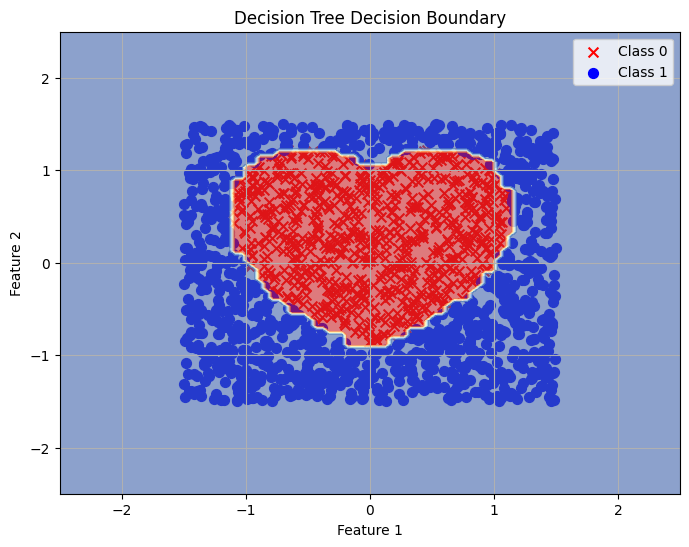

In [12]:
for tree in decision_trees:
    img = visualizeTree(tree, test_set)

## 3 - Using sklearn

c:\Users\Nicor\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


n=32, Number of nodes: 11, Test Error: 0.1338
n=128, Number of nodes: 21, Test Error: 0.0874
n=512, Number of nodes: 59, Test Error: 0.0470
n=2048, Number of nodes: 121, Test Error: 0.0232
n=8192, Number of nodes: 249, Test Error: 0.0100


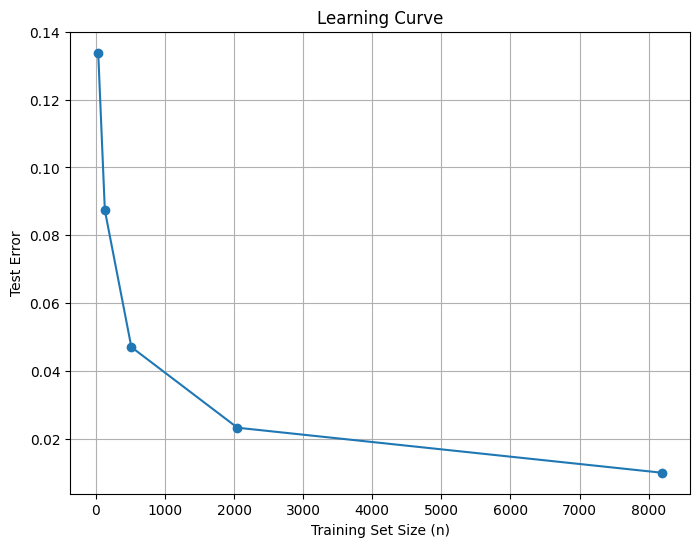

In [25]:
from sklearn.tree import DecisionTreeClassifier

training_sets = []
decision_trees = []
n_values = [32, 128, 512, 2048, 8192]

for n in n_values:
    # Take the first n items from the shuffled training set
    subset = training_set[:n]
    X_subset = subset[:, :-1]
    y_subset = subset[:, -1]

    # Train a decision tree on the subset
    tree = DecisionTreeClassifier()
    tree.fit(X_subset, y_subset)

    # Append the subset and the corresponding decision tree
    training_sets.append(subset)
    decision_trees.append(tree)

test_errors = []

for tree in decision_trees:
    X_test = test_set[:, :-1]
    y_test = test_set[:, -1]

    # Measure test set error
    test_error = 1 - tree.score(X_test, y_test)
    test_errors.append(test_error)

# Print and plot the results
for n, tree, error in zip(n_values, decision_trees, test_errors):
    print(f"n={n}, Number of nodes: {tree.tree_.node_count}, Test Error: {error:.4f}")

# Plot the learning curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(n_values, test_errors, marker='o')
plt.xlabel('Training Set Size (n)')
plt.ylabel('Test Error')
plt.title('Learning Curve')
plt.grid(True)
plt.show()
